## Classify the flowers shown in the flower dataset

* The flowers are in color and you'll have to work with that. You can't turn them to greyscale etc.
* Data augmentation is allowed here due to popular complaint, but the problem can be completed without it




In [1]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import torch
from torchvision import datasets,models, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# !pip install torchsummary 
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True

/home/anirudh/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading the Training and Testing Data using Data Loader with Data Augmentation

In [2]:
# Loading the Training and Testing Data
trainImages = np.load('./Flowers/flower_imgs.npy')
trainLabels = np.load('./Flowers/flower_labels.npy')
# Splitting the Data into Training and Test Data
X_train, X_test,Y_train,Y_test = train_test_split(trainImages,trainLabels, test_size=0.15, shuffle = True)

# Finding the mean and the Variance
img_mean = np.mean(np.swapaxes(trainImages/255.0,0,1).reshape(3, -1), 1)
img_std = np.std(np.swapaxes(trainImages/255.0,0,1).reshape(3, -1), 1)
print("mean: {}, std: {}".format(img_mean, img_std))


mean: [0.43430043 0.43250865 0.35484957], std: [0.28290703 0.26667351 0.25423616]


In [3]:
class FlowerLoader(torch.utils.data.Dataset):
    def __init__(self, x_arr, y_arr, transform=None):
        self.x_arr = x_arr
        self.y_arr = y_arr
        self.transform = transform

    def __len__(self):
        return self.x_arr.shape[0]

    def __getitem__(self, index):
        img = self.x_arr[index]
        label = self.y_arr[index]
        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [4]:
## Normalizing the Data
normalize = transforms.Normalize(mean=list(img_mean),std=list(img_std))
batch_size =64

train_loader = torch.utils.data.DataLoader(
    FlowerLoader(X_train, Y_train, transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=True)
# remove augmentation transforms in test loader
test_loader = torch.utils.data.DataLoader(
    FlowerLoader(X_test, Y_test, transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False)

In [5]:
# sample for iterating over loader
# for img, label in train_loader:
#     img, label = img.to(device), label.to(device)

# Showing the Input Data 

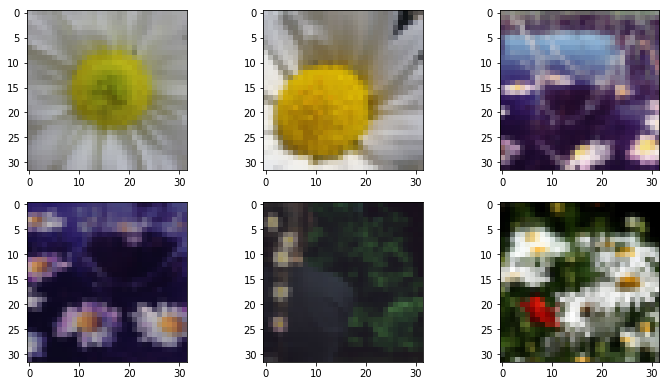

In [6]:
# Preview the training data
plt.figure(figsize=(12,10))# Showing the Input Data after Normalizing
x, y = 3, 3
for i in range(6):  
    plt.subplot(y, x, i+1)
    plt.imshow(trainImages[i],interpolation='nearest')
plt.show()

## Defining Convolution Neural Network

In [7]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512 ,512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = self._make_layers_linear()

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif x == 'D':
                layers+= [nn.Dropout(0.4)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.PReLU()]#inplace=True
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    def _make_layers_linear(self):
        layers = []
        layers +=[nn.Linear(512, 5)]
#         layers += [nn.Linear(256, 64)]
#         layers += [nn.Linear(64, 5)]
        return nn.Sequential(*layers)

In [8]:


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # 3 input image channel, 6 output channels, 5x5 square convolution
#         # kernel
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 5)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
#     def num_flat_features(s|elf, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features

# net = Net()
# net.to(device)
net = VGG('VGG13')
net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=1)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): PReLU(num_parameters=1)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

In [9]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
             PReLU-3           [-1, 64, 32, 32]               1
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
             PReLU-6           [-1, 64, 32, 32]               1
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
            PReLU-10          [-1, 128, 16, 16]               1
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
            PReLU-13          [-1, 128, 16, 16]               1
        MaxPool2d-14            [-1, 12

In [10]:
params = list(net.parameters())
# print(len(params))
# print(params[0].size())  # conv1's .weight
# params

##  Define a Loss function and optimizer

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay = 5e-4)
optimizer = optim.Adam(params, lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]

In [12]:
# output = net(data)
# #         print(target.dtype,output.dtype)
# loss = criterion(output, target)
# loss.backward()
# optimizer.step()

## Training and Testing

In [13]:
def train(model, train_loader, optimizer, epoch,device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
#         print(target.shape,output.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        lo.append(loss.item())
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += train_pred.eq(target.view_as(train_pred)).sum().item()
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    testlo = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            test_loss = criterion(output, target)
            testlo.append(test_loss.item())
#             print(test_loss)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_accu.append(100. * correct / len(test_loader.dataset))
#     test_loss /= len(test_loader.dataset)
    val_loss.append(np.mean(testlo))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(testlo), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Training the Model

In [14]:
epochs = 100
for epoch in range(1, epochs + 1):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 1 [0/3674 (0%)]	Loss: 1.659776
Train Epoch: 1 [640/3674 (17%)]	Loss: 1.480836
Train Epoch: 1 [1280/3674 (34%)]	Loss: 1.293570
Train Epoch: 1 [1920/3674 (52%)]	Loss: 1.263038
Train Epoch: 1 [2560/3674 (69%)]	Loss: 1.176953
Train Epoch: 1 [3200/3674 (86%)]	Loss: 1.251764

Test set: Average loss: 1.3700, Accuracy: 319/649 (49%)

Train Epoch: 2 [0/3674 (0%)]	Loss: 1.258612
Train Epoch: 2 [640/3674 (17%)]	Loss: 1.339629
Train Epoch: 2 [1280/3674 (34%)]	Loss: 0.988703
Train Epoch: 2 [1920/3674 (52%)]	Loss: 1.023077
Train Epoch: 2 [2560/3674 (69%)]	Loss: 1.125624
Train Epoch: 2 [3200/3674 (86%)]	Loss: 1.094267

Test set: Average loss: 1.0749, Accuracy: 356/649 (55%)

Train Epoch: 3 [0/3674 (0%)]	Loss: 1.002915
Train Epoch: 3 [640/3674 (17%)]	Loss: 0.939196
Train Epoch: 3 [1280/3674 (34%)]	Loss: 1.060066
Train Epoch: 3 [1920/3674 (52%)]	Loss: 1.183596
Train Epoch: 3 [2560/3674 (69%)]	Loss: 0.871834
Train Epoch: 3 [3200/3674 (86%)]	Loss: 0.852168

Test set: Average loss: 1.0453, Ac


Test set: Average loss: 0.8937, Accuracy: 440/649 (68%)

Train Epoch: 25 [0/3674 (0%)]	Loss: 0.582258
Train Epoch: 25 [640/3674 (17%)]	Loss: 0.485116
Train Epoch: 25 [1280/3674 (34%)]	Loss: 0.810156
Train Epoch: 25 [1920/3674 (52%)]	Loss: 0.579025
Train Epoch: 25 [2560/3674 (69%)]	Loss: 0.393884
Train Epoch: 25 [3200/3674 (86%)]	Loss: 0.504580

Test set: Average loss: 0.7910, Accuracy: 469/649 (72%)

Train Epoch: 26 [0/3674 (0%)]	Loss: 0.479366
Train Epoch: 26 [640/3674 (17%)]	Loss: 0.468274
Train Epoch: 26 [1280/3674 (34%)]	Loss: 0.573234
Train Epoch: 26 [1920/3674 (52%)]	Loss: 0.403367
Train Epoch: 26 [2560/3674 (69%)]	Loss: 0.373570
Train Epoch: 26 [3200/3674 (86%)]	Loss: 0.369887

Test set: Average loss: 0.9993, Accuracy: 449/649 (69%)

Train Epoch: 27 [0/3674 (0%)]	Loss: 0.358051
Train Epoch: 27 [640/3674 (17%)]	Loss: 0.348473
Train Epoch: 27 [1280/3674 (34%)]	Loss: 0.413396
Train Epoch: 27 [1920/3674 (52%)]	Loss: 0.781294
Train Epoch: 27 [2560/3674 (69%)]	Loss: 0.436307
Train Ep

Train Epoch: 48 [2560/3674 (69%)]	Loss: 0.241968
Train Epoch: 48 [3200/3674 (86%)]	Loss: 0.249059

Test set: Average loss: 1.0377, Accuracy: 493/649 (76%)

Train Epoch: 49 [0/3674 (0%)]	Loss: 0.210491
Train Epoch: 49 [640/3674 (17%)]	Loss: 0.251991
Train Epoch: 49 [1280/3674 (34%)]	Loss: 0.415648
Train Epoch: 49 [1920/3674 (52%)]	Loss: 0.204384
Train Epoch: 49 [2560/3674 (69%)]	Loss: 0.512831
Train Epoch: 49 [3200/3674 (86%)]	Loss: 0.301933

Test set: Average loss: 1.2031, Accuracy: 426/649 (66%)

Train Epoch: 50 [0/3674 (0%)]	Loss: 0.245653
Train Epoch: 50 [640/3674 (17%)]	Loss: 0.286405
Train Epoch: 50 [1280/3674 (34%)]	Loss: 0.443195
Train Epoch: 50 [1920/3674 (52%)]	Loss: 0.195738
Train Epoch: 50 [2560/3674 (69%)]	Loss: 0.129200
Train Epoch: 50 [3200/3674 (86%)]	Loss: 0.401950

Test set: Average loss: 0.8160, Accuracy: 501/649 (77%)

Train Epoch: 51 [0/3674 (0%)]	Loss: 0.040730
Train Epoch: 51 [640/3674 (17%)]	Loss: 0.436692
Train Epoch: 51 [1280/3674 (34%)]	Loss: 0.358178
Train Ep

Train Epoch: 72 [1280/3674 (34%)]	Loss: 0.066958
Train Epoch: 72 [1920/3674 (52%)]	Loss: 0.117220
Train Epoch: 72 [2560/3674 (69%)]	Loss: 0.120377
Train Epoch: 72 [3200/3674 (86%)]	Loss: 0.246113

Test set: Average loss: 1.0679, Accuracy: 487/649 (75%)

Train Epoch: 73 [0/3674 (0%)]	Loss: 0.193243
Train Epoch: 73 [640/3674 (17%)]	Loss: 0.235150
Train Epoch: 73 [1280/3674 (34%)]	Loss: 0.249081
Train Epoch: 73 [1920/3674 (52%)]	Loss: 0.258423
Train Epoch: 73 [2560/3674 (69%)]	Loss: 0.116136
Train Epoch: 73 [3200/3674 (86%)]	Loss: 0.146616

Test set: Average loss: 1.0356, Accuracy: 487/649 (75%)

Train Epoch: 74 [0/3674 (0%)]	Loss: 0.052157
Train Epoch: 74 [640/3674 (17%)]	Loss: 0.202838
Train Epoch: 74 [1280/3674 (34%)]	Loss: 0.168517
Train Epoch: 74 [1920/3674 (52%)]	Loss: 0.149431
Train Epoch: 74 [2560/3674 (69%)]	Loss: 0.335123
Train Epoch: 74 [3200/3674 (86%)]	Loss: 0.158222

Test set: Average loss: 1.2866, Accuracy: 464/649 (71%)

Train Epoch: 75 [0/3674 (0%)]	Loss: 0.358255
Train E

Train Epoch: 96 [640/3674 (17%)]	Loss: 0.124882
Train Epoch: 96 [1280/3674 (34%)]	Loss: 0.168300
Train Epoch: 96 [1920/3674 (52%)]	Loss: 0.057645
Train Epoch: 96 [2560/3674 (69%)]	Loss: 0.068637
Train Epoch: 96 [3200/3674 (86%)]	Loss: 0.191926

Test set: Average loss: 0.9686, Accuracy: 484/649 (75%)

Train Epoch: 97 [0/3674 (0%)]	Loss: 0.089189
Train Epoch: 97 [640/3674 (17%)]	Loss: 0.077428
Train Epoch: 97 [1280/3674 (34%)]	Loss: 0.248276
Train Epoch: 97 [1920/3674 (52%)]	Loss: 0.240781
Train Epoch: 97 [2560/3674 (69%)]	Loss: 0.259198
Train Epoch: 97 [3200/3674 (86%)]	Loss: 0.122228

Test set: Average loss: 1.1721, Accuracy: 435/649 (67%)

Train Epoch: 98 [0/3674 (0%)]	Loss: 0.178307
Train Epoch: 98 [640/3674 (17%)]	Loss: 0.082063
Train Epoch: 98 [1280/3674 (34%)]	Loss: 0.106739
Train Epoch: 98 [1920/3674 (52%)]	Loss: 0.177573
Train Epoch: 98 [2560/3674 (69%)]	Loss: 0.265311
Train Epoch: 98 [3200/3674 (86%)]	Loss: 0.063050

Test set: Average loss: 0.7387, Accuracy: 508/649 (78%)

Trai

Training Loss: 0.12804663695138077
Training Accuracy: 95.83560152422427

Test Loss: 0.9429731271145018
Testing Accuracy: 80.73959938366718



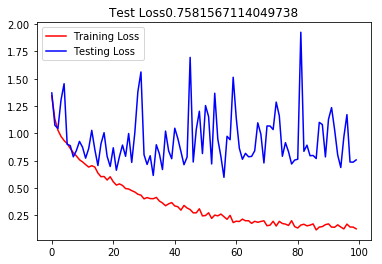

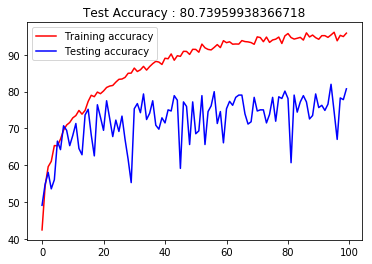

In [15]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', np.mean(val_loss))
print('Testing Accuracy:', test_accu[-1])
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(test_accu[-1]))
plt.legend()
plt.show()

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
model_ft

NameError: name 'model_ft' is not defined

In [ ]:
summary(model_ft,(3,32,32))